In [1]:
import pandas as pd
import numpy as np

import torch

import data_utils.pulse as pulse #sean's code
import models.rf as models_rf
import models.fcnn as models_fcnn
import models.vae as models_vae

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

In [3]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

## Read dataset

In [4]:
filename='datasets/galadriel_dataset_25_05_20a.h5'

df_input=pd.read_hdf(filename,'df_input')#dazzler parameters + goodness
df_time=pd.read_hdf(filename,'df_time') #wizzler pulse shape data, first row is the time values

df_time_val=df_time.loc[0]
df_time= df_time.drop([0]) #drop the time values
df_time.reset_index(inplace=True,drop=True) #to start again from 0

#frequency, intesity and phase from the Wizzler (used to reconstruct pulse using Sean's code)
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

## Pulse reconstruction

In [5]:
#time in fs (it is the boundary)
def pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [6]:
filename_pulse='datasets/pulse_250520a.h5'

In [7]:
#read the data
df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

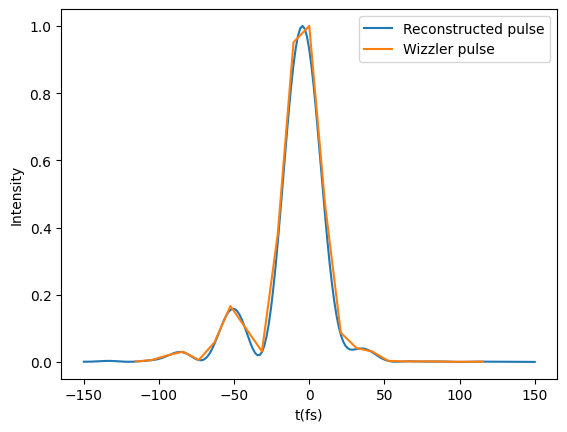

In [8]:
shot_index=35
plt.plot(t_200,df_pulse_200.iloc[shot_index],label='Reconstructed pulse')
plt.plot(df_time_val,df_time.iloc[shot_index],label='Wizzler pulse')
plt.xlabel('t(fs)')
plt.ylabel('Intensity')
plt.legend()

## Create the training/test datasets

(Here we should do some cleaning. Remove bad goodness shots....)

In [9]:
#DROP SHOTS witl low goodness
goodness_val=1.2
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values

df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [10]:
#X: df_input (Dazzler parameters)
#Y: df_pulse (Pulse shapes)
X=df_input_reduced[['order2','order3','order4']]
y=df_pulse_200_reduced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [11]:
X_train

,order2,order3,order4
880,34900.0,-3500.0,-4600000.0
267,34500.0,5500.0,-4300000.0
346,34600.0,-18500.0,-4600000.0
1078,35100.0,-15500.0,-5200000.0
1106,35100.0,-8000.0,-4900000.0
...,...,...,...
1417,35300.0,16000.0,-4300000.0
75,34400.0,-500.0,-4000000.0
599,34700.0,-11000.0,-4600000.0
1361,35300.0,1000.0,-5200000.0


## Model training (Forward)

### Random forest

In [12]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    #HYPERPARAMETERS
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=models_rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=models_rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf

In [13]:
%%time
forward_model_rf=train_rf_forward(X_train, X_test, y_train, y_test)

CPU times: user 1.75 s, sys: 139 ms, total: 1.89 s
Wall time: 1.89 s


### Multi-layer perceptron (MLP)

In [14]:
device='cpu' #could be gpus if available
forward_model_mlp=models_fcnn.FWmodelNN(X_train,y_train,X_test,y_test,device)
forward_model_mlp.train(100,#epochs 
                 128,#batch size
                 10, #print freq
                 0.001) #learning rate
y_predict_nn_fwd=forward_model_mlp.predict(X_test)
error_fwd_model_mlp=forward_model_mlp.error_calc_mae()

Finished epoch 0,latest loss 0.059324610978364944
Finished epoch 10,latest loss 0.0011762777576223016
Finished epoch 20,latest loss 0.0008315759478136897
Finished epoch 30,latest loss 0.0006534490967169404
Finished epoch 40,latest loss 0.00029484424157999456
Finished epoch 50,latest loss 0.0001438817853340879
Finished epoch 60,latest loss 9.597463213140145e-05
Finished epoch 70,latest loss 7.350597297772765e-05
Finished epoch 80,latest loss 6.183912046253681e-05
Finished epoch 90,latest loss 5.45033544767648e-05
Finished epoch 99,latest loss 5.0679416744969785e-05
Total time taken to train the model: 3.90s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

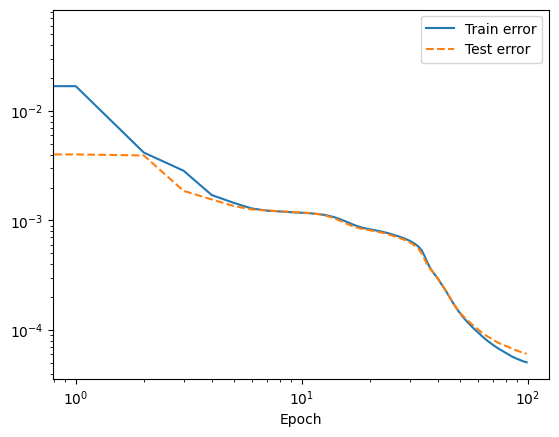

In [15]:
plt.plot(forward_model_mlp.train_error,label='Train error')
plt.plot(forward_model_mlp.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

In [16]:
def plot_example(shot_index,X_test,y_test,df_input,df_time_val,
                 forward_model_rf,forward_model_mlp):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=X_test.iloc[shot_index].values
    
    X_values=pd.DataFrame([X_test.iloc[shot_index]])
    y_predict_forward_rf=models_rf.make_rf_prediction(forward_model_rf,X_values)
    y_predict_forward_nn=forward_model_mlp.predict(X_values)
    
    plt.plot(df_time_val,y_test.iloc[shot_index],label='Real shot (#'+str(shot_numb)+')',linewidth=3)
    plt.plot(df_time_val,y_predict_forward_rf[0],label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time_val,y_predict_forward_nn[0],label='Prediction (MLP)',linewidth=3,linestyle='-.')
    
    mae_rf=abs(y_test.iloc[shot_index]-y_predict_forward_rf[0])
    mae_rf=mae_rf.sum()/len(y_test.iloc[shot_index])

    mae_mlp=abs(y_test.iloc[shot_index]-y_predict_forward_nn[0])
    mae_mlp=mae_mlp.sum()/len(y_test.iloc[shot_index])

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test.iloc[shot_index],y_predict_forward[shot_index]))
    plt.title('Forward predictions',fontsize=14)
    plt.text(45, 0.65, r'$\beta_2=$'+str(order2), dict(size=14))
    plt.text(45, 0.55, r'$\beta_3=$'+str(order3), dict(size=14))
    plt.text(45, 0.45, r'$\beta_4=$'+str(order4), dict(size=14))
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf))
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

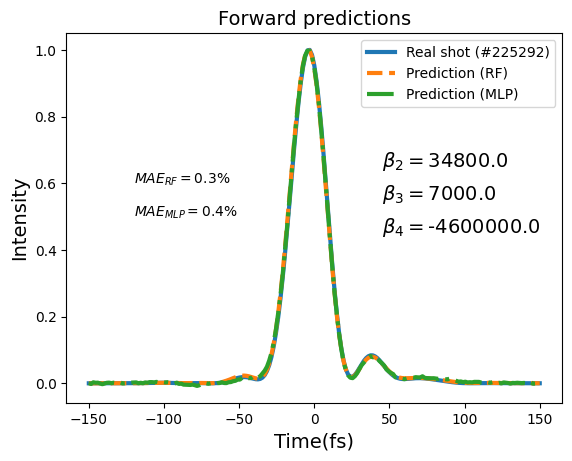

In [17]:
shot_index=120
plot_example(shot_index,X_test,y_test,df_input_reduced,t_200,
             forward_model_rf,forward_model_mlp)

# **** ROUNDTRIP MODELS  *****

### Random Forest

In [18]:
%%time
roundmodel_rf=models_rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round=roundmodel_rf.predict(y_test)

Training the Random Forest forward model
Training the Random Forest backward model
CPU times: user 36.7 s, sys: 126 ms, total: 36.8 s
Wall time: 36.8 s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### MLP

In [19]:
#round model NN
roundmodel_mlp=models_fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodel_mlp.train(100,#epochs FWD
                 128,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   400,#epochs  BWD
                 128,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodel_mlp.predict(y_test)

Training the forward model
Finished epoch 0,latest loss 0.06153872609138489
Finished epoch 20,latest loss 0.0007536867051385343
Finished epoch 40,latest loss 0.0001660273119341582
Finished epoch 60,latest loss 9.931757813319564e-05
Finished epoch 80,latest loss 7.066149555612355e-05
Finished epoch 99,latest loss 5.8643214288167655e-05
Total time taken to train the model: 3.46s
Training the backward model
Finished epoch 0,latest loss 1.0133219957351685
Finished epoch 50,latest loss 0.11280817538499832
Finished epoch 100,latest loss 0.03281388431787491
Finished epoch 150,latest loss 0.020865967497229576
Finished epoch 200,latest loss 0.015584604814648628
Finished epoch 250,latest loss 0.013268735259771347
Finished epoch 300,latest loss 0.012134812772274017
Finished epoch 350,latest loss 0.008611738681793213
Finished epoch 399,latest loss 0.00869046337902546
Total time taken to train the model: 5.91s


Text(0.5, 0, 'Epoch')

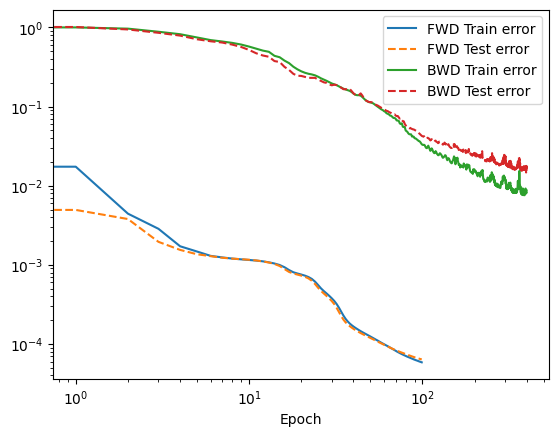

In [20]:
plt.plot(roundmodel_mlp.train_error_fwd,label='FWD Train error')
plt.plot(roundmodel_mlp.test_error_fwd,linestyle='--',label='FWD Test error')
plt.plot(roundmodel_mlp.train_error_bwd,label='BWD Train error')
plt.plot(roundmodel_mlp.test_error_bwd,linestyle='--',label='BWD Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### CVAE

In [21]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
cvae=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
)
#if you want to see a description of the network
#batch_size = 10#just as an example
#y_length=len(t_200)
#x_length=len(X_train.columns)
#summary(cvae,[(batch_size,x_length),(batch_size,y_length)]) #from torchinfo import summary

In [22]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			cvae,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

Training on: cpu
Finished epoch 0,latest loss 0.8582248091697693
Finished epoch 20,latest loss 0.07746434956789017
Finished epoch 40,latest loss 0.04337576776742935
Finished epoch 60,latest loss 0.03633236885070801
Finished epoch 80,latest loss 0.028605226427316666
Finished epoch 100,latest loss 0.03139721602201462
Finished epoch 120,latest loss 0.016692213714122772
Finished epoch 140,latest loss 0.016898801550269127
Finished epoch 160,latest loss 0.009763902053236961
Finished epoch 180,latest loss 0.014347173273563385
Finished epoch 200,latest loss 0.007120097987353802
Finished epoch 220,latest loss 0.006835159845650196
Finished epoch 240,latest loss 0.006532877217978239
Finished epoch 260,latest loss 0.005641779862344265
Finished epoch 280,latest loss 0.004472451750189066
Finished epoch 299,latest loss 0.004483712837100029
Total time taken to train the model: 50.74s


Text(0.5, 0, 'Epoch')

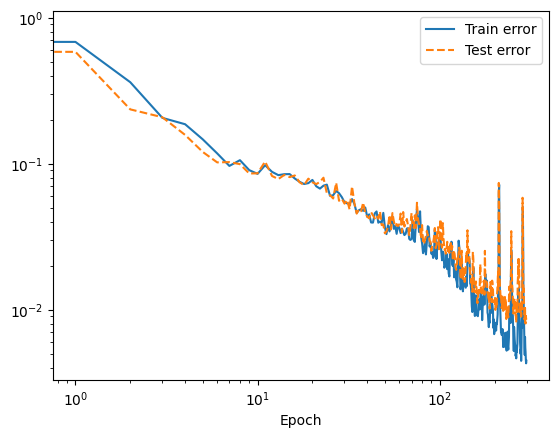

In [23]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

## Testing the predictions from the Roundtrip models

In [24]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,y_test,device):
    #index_shot=150
    y_ex=y_test.iloc[index_shot]
    X_ex=X_test.iloc[index_shot]
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    print(len(y_ex))
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex)))
    print('Known Dazzler values',X_ex)

    shot_numb=get_shot_num(index_shot,y_test,df_input)


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    
    y_order2=np.linspace(0,1,10)
    x_order2=np.full_like(y_order2,X_ex['order2'])

    y_order3=np.linspace(0,1,10)
    x_order3=np.full_like(y_order3,X_ex['order3'])

    y_order4=np.linspace(0,1,10)
    x_order4=np.full_like(y_order4,X_ex['order4'])


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    mae_rf=abs(y_ex-y_predict_round_rf)
    mae_rf=mae_rf.sum()/len(y_ex)

    mae_mlp=abs(y_ex-y_predict_round_nn_cust)
    mae_mlp=mae_mlp.sum()/len(y_ex)

    mae_cvae=abs(y_ex-y_pred_fwd_cvae)
    mae_cvae=mae_cvae.sum()/len(y_ex)

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Real shot (#'+str(shot_numb)+')',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3,color='tab:orange')
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3,color='tab:green')
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3,color='tab:red')
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf),fontsize=16)
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp),fontsize=16)
    plt.text(-120,0.4,r'$MAE_{{CVAE}}={:.1f}$%'.format(100*mae_cvae),fontsize=16)
    plt.ylabel('Intensity',size=15)
    plt.xlabel('t(fs)',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order2,y_order2,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o2_rf,y_o2_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o2_nn,y_o2_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_2$',size=15)
    #plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 1)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_x)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_x|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order3,y_order3,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o3_rf,y_o3_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o3_nn,y_o3_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 1)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred $P(\beta_4|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order4,y_order4,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o4_rf,y_o4_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o4_nn,y_o4_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_4$',size=15)
    #plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

201
Known Dazzler values order2      34900.0
order3      11500.0
order4   -4900000.0
Name: 934, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


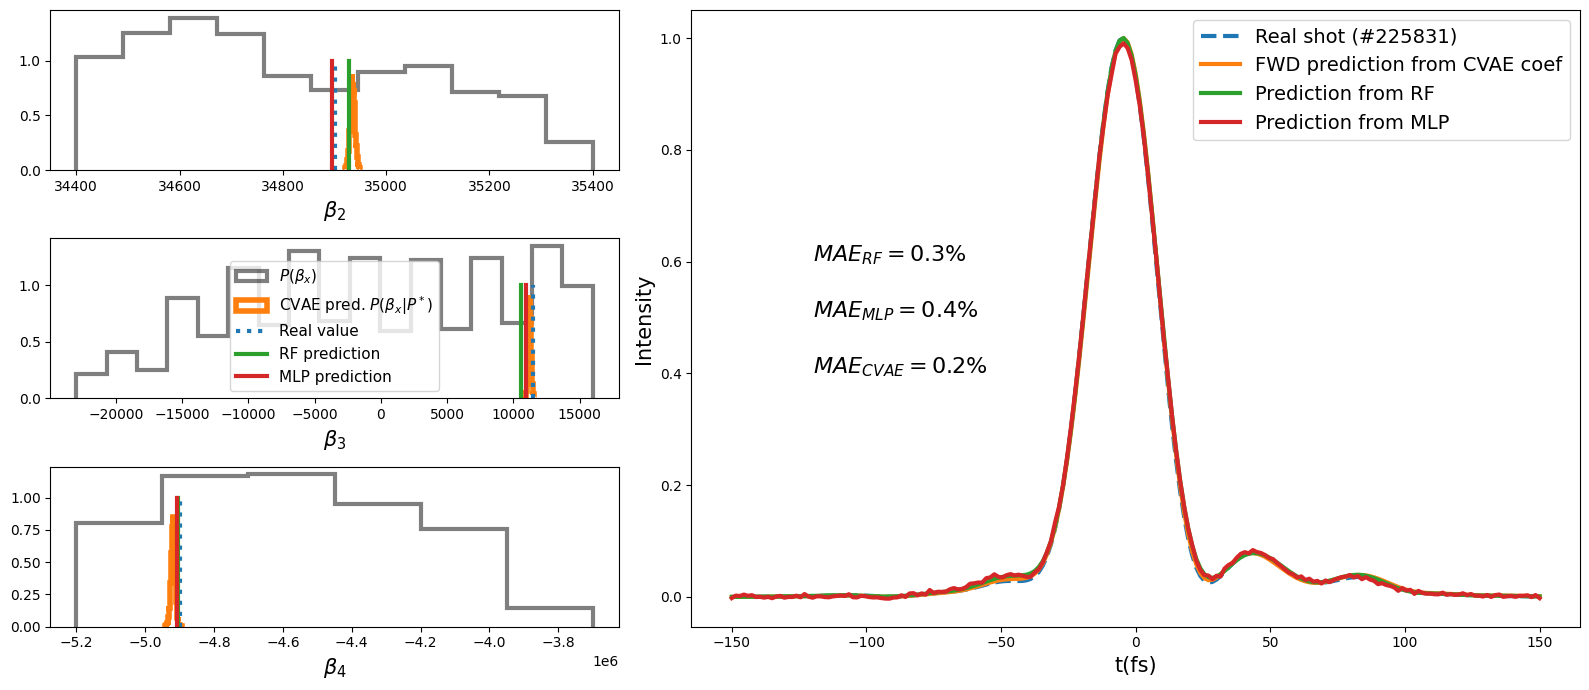

In [25]:
index_shot=106
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

# CUSTOM SHOTS

**NOTE**: The CVAE model was executed on GALADRIEL system and the predicted Dazzler coefficients were used. So here we don't take into account the backward prediction because could be different thant the one obtained that day and the ones calculated in my laptop.

In the experiment, 4 shots were executed for each custom shot

### Read the dataset from the prediction run

In [26]:
filename_pred='datasets/galadriel_dataset_25_05_20a_pred.h5'

df_input_pred=pd.read_hdf(filename_pred,'df_input')#dazzler parameters + goodness

In [27]:
df_input_pred

,shot number,order2,order3,order4,goodness
0,228358,34782.292969,14733.736328,-4662738.000,1.163022
1,228359,34782.292969,14733.736328,-4662738.000,1.192154
2,228360,34782.292969,14733.736328,-4662738.000,1.151871
3,228361,34782.292969,14733.736328,-4662738.000,1.193078
4,228362,33329.222656,16434.253906,-3184123.250,1.134150
5,228363,33329.222656,16434.253906,-3184123.250,1.126749
6,228364,33329.222656,16434.253906,-3184123.250,1.144016
7,228365,33329.222656,16434.253906,-3184123.250,1.132594
8,228366,31618.500000,-20568.347656,-1252228.125,0.987530
9,228367,31618.500000,-20568.347656,-1252228.125,0.999243


### Pulse reconstruction

In [28]:
#frequency, intesity and phase from the Wizzler (used to reconstruct pulse using Sean's code)
df_spec_freq_pred=pd.read_hdf(filename_pred,'df_spec_freq')
df_spec_int_pred=pd.read_hdf(filename_pred,'df_spec_int')
df_spec_phase_pred=pd.read_hdf(filename_pred,'df_spec_phase')

In [29]:
filename_pulse_pred='datasets/pulse_250520a_pred.h5'

In [30]:
#read the data
df_time_200_pred=pd.read_hdf(filename_pulse_pred,'df_time_200')
df_pulse_200_pred=pd.read_hdf(filename_pulse_pred,'df_pulse_200')
t_200_pred=df_time_200_pred.to_numpy()

In [31]:
df_pulse_200_pred.iloc[0]

0      0.000003
1      0.000004
2      0.000009
3      0.000015
4      0.000024
         ...   
196    0.000257
197    0.000218
198    0.000181
199    0.000148
200    0.000123
Name: 0, Length: 201, dtype: float64

In [32]:
#Take a custom pulse shpae (y_ex) and get the predicted Dazz and pulse shape from CVAE.
# Then the pulse is compared with the value from the exp run
# X_train in the input is the dataset used to normalized the X
# Pass the df_input_pred as a Series with only one shot
def pred_cust_cvae(y_ex,model_cvae,forward_model_rf,
                   t_200,X_train,device,
                  t_200_pred,y_pred,df_input_pred):
    y_ex_tensor=torch.tensor(y_ex,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    num_bins=100

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    mae_cvae=abs(y_pred-y_pred_fwd_cvae)
    mae_cvae=mae_cvae.sum()/len(y_pred)

    print('PREDICTIONS (in my laptop):')
    print('*CVAE:')
    print(' -Order2:',o2_pred)
    print(' -Order3:',o3_pred)
    print(' -Order4:',o4_pred)

    shot_numb=int(df_input_pred["shot number"])#get_shot_num(shot_index,y_test,df_input)
    order2="{:.1f}".format(df_input_pred["order2"])#get teh value and convert to str with 1value after .
    order3="{:.1f}".format(df_input_pred["order3"])
    order4="{:.1f}".format(df_input_pred["order4"])
    #order2,order3,order4=X_test.iloc[shot_index].values

    plt.plot(t_200,y_ex,label='Custom shot',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae,label='CVAE prediction',linewidth=3,color='tab:orange')
    plt.plot(t_200_pred,y_pred,label='Real shot (#'+str(shot_numb)+')',linewidth=3,color='tab:green')

   
    plt.title('Custom shots: prediction and result',fontsize=14)
    plt.text(45, 0.65, r'$\beta_2=$'+order2, dict(size=14))
    plt.text(45, 0.55, r'$\beta_3=$'+order3, dict(size=14))
    plt.text(45, 0.45, r'$\beta_4=$'+order4, dict(size=14))
    plt.text(-120,0.6,r'$MAE_{{pred}}={:.1f}$%'.format(100*mae_cvae))
    #plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

In [33]:
#define the curve to fit (the custom pulse shape)
# It's just 5 gaussians
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

In [34]:
order2=df_input_pred.iloc[0]["order2"]

In [35]:
"{:.1f}".format(order2)

'34782.3'

PREDICTIONS (in my laptop):
*CVAE:
 -Order2: 34788.734
 -Order3: 14197.479
 -Order4: -4725212.5


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


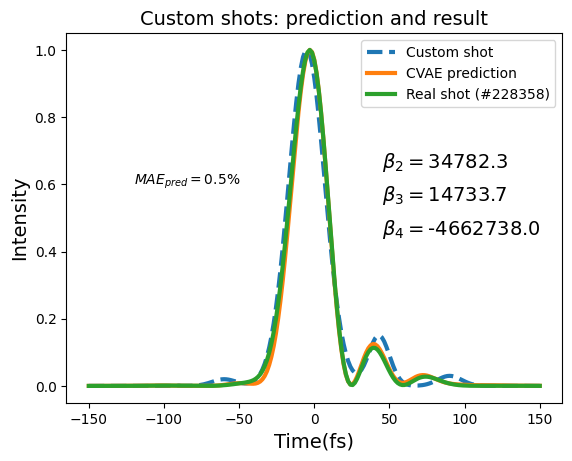

In [36]:
#FIRST SHOT
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.02,-60,8,
                 1,-5,12,
                 0.15,+43,7,
                 0.03,+90,8)

pred_shot_index=0
y_pred=df_pulse_200_pred.iloc[pred_shot_index]
meta_pred=df_input_pred.iloc[pred_shot_index]

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
               t_200,X_train,device,
              t_200_pred,y_pred,meta_pred)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS (in my laptop):
*CVAE:
 -Order2: 33636.73
 -Order3: 25262.37
 -Order4: -3671290.8


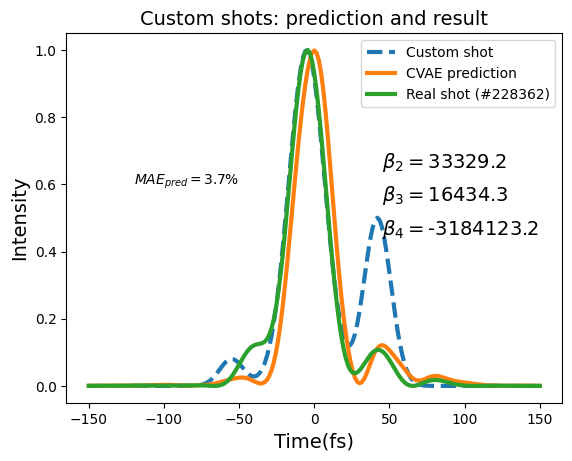

In [37]:
#SECOND SHOT
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.08,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_shot_index=4
y_pred=df_pulse_200_pred.iloc[pred_shot_index]
meta_pred=df_input_pred.iloc[pred_shot_index]

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
               t_200,X_train,device,
              t_200_pred,y_pred,meta_pred)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS (in my laptop):
*CVAE:
 -Order2: 32678.346
 -Order3: -25347.066
 -Order4: -3201420.0


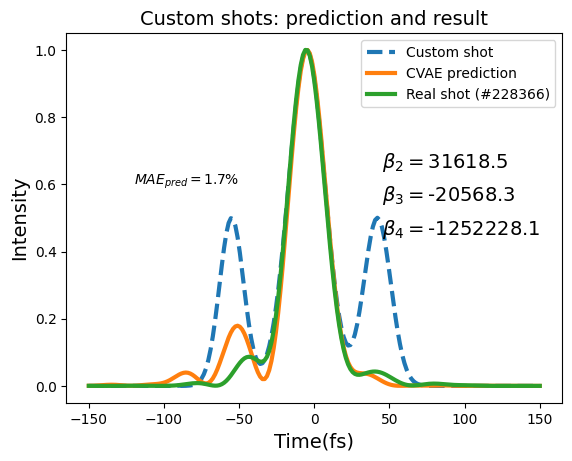

In [38]:
#THIRD SHOT
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.5,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_shot_index=8
y_pred=df_pulse_200_pred.iloc[pred_shot_index]
meta_pred=df_input_pred.iloc[pred_shot_index]

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
               t_200,X_train,device,
              t_200_pred,y_pred,meta_pred)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS (in my laptop):
*CVAE:
 -Order2: 34611.797
 -Order3: -16287.888
 -Order4: -3911442.8


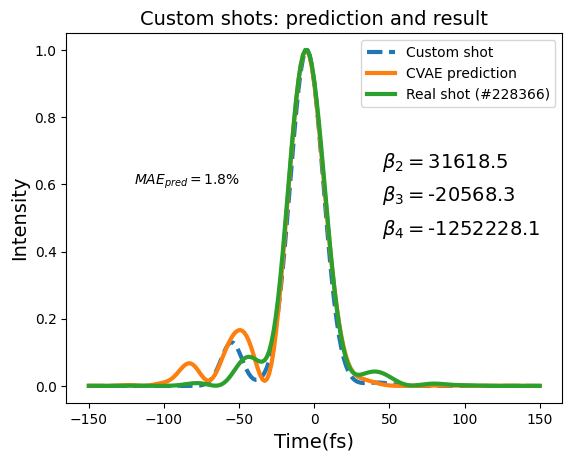

In [39]:
#FORTH SHOT
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.13,-55,7,
                 1,-5,11,
                 0.01,+42,9,
                 0.00,+90,8)

pred_shot_index=8
y_pred=df_pulse_200_pred.iloc[pred_shot_index]
meta_pred=df_input_pred.iloc[pred_shot_index]

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
               t_200,X_train,device,
              t_200_pred,y_pred,meta_pred)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS (in my laptop):
*CVAE:
 -Order2: 34662.23
 -Order3: -10659.783
 -Order4: -4221804.0


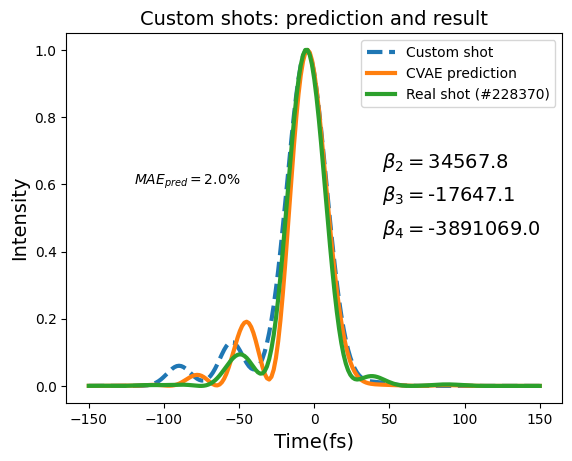

In [40]:
#FIFTH SHOT
y_cust_shot=func(t_200,
                 0.06,-90,8,
                 0.13,-55,8,
                 1,-5,13,
                 0.01,+42,9,
                 0.00,+90,8)

pred_shot_index=12
y_pred=df_pulse_200_pred.iloc[pred_shot_index]
meta_pred=df_input_pred.iloc[pred_shot_index]

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
               t_200,X_train,device,
              t_200_pred,y_pred,meta_pred)